In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification


In [ ]:
df = pd.read_json('/Sarcasm_Headlines_Dataset.json', lines=True)

print(df.head())



                                        article_link  \
0  https://www.huffingtonpost.com/entry/versace-b...   
1  https://www.huffingtonpost.com/entry/roseanne-...   
2  https://local.theonion.com/mom-starting-to-fea...   
3  https://politics.theonion.com/boehner-just-wan...   
4  https://www.huffingtonpost.com/entry/jk-rowlin...   

                                            headline  is_sarcastic  
0  former versace store clerk sues over secret 'b...             0  
1  the 'roseanne' revival catches up to our thorn...             0  
2  mom starting to fear son's web series closest ...             1  
3  boehner just wants wife to listen, not come up...             1  
4  j.k. rowling wishes snape happy birthday in th...             0  


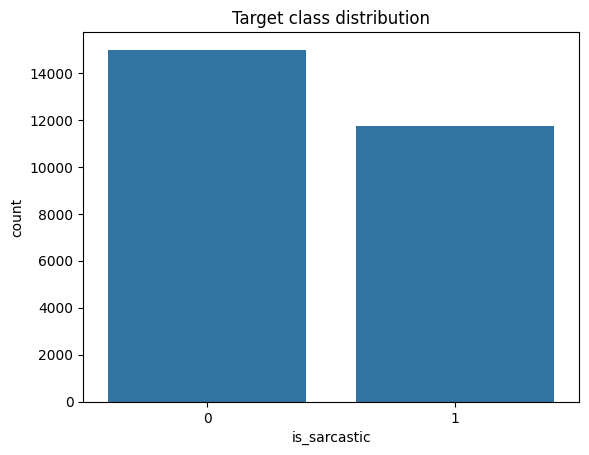

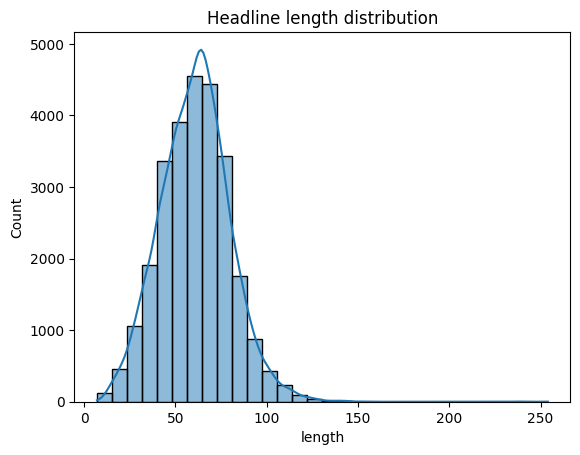

['pre-teen moves from giggling-at-everything phase to never-smiling phase'
 'sasha obama orders secret service agent to stop squirming during makeover'
 'family dinner successfully covers topics of movies and tv'
 'area spoon only rinsed for past 18 months'
 'sanders campaign headquarters smashed up by gang of pinkerton union busters']
['this ned flanders-themed band is now the best band (sorry, all other bands)'
 'recent mlb incidents reveal warped ideas of manhood in sports'
 "friday's morning email: hackers reportedly target u.s. nuclear plants"
 "trump's possible pardon of joe arpaio is destructive and unpresidential"
 "oregon's new travel video may inspire acid trips more than vacations"]


In [ ]:
sns.countplot(x='is_sarcastic', data=df)
plt.title('Target class distribution')
plt.show()

df['length'] = df['headline'].apply(len)
sns.histplot(df['length'], bins=30, kde=True)
plt.title('Headline length distribution')
plt.show()

print(df[df['is_sarcastic']==1]['headline'].sample(5).values)
print(df[df['is_sarcastic']==0]['headline'].sample(5).values)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df['headline'].values, df['is_sarcastic'].values, test_size=0.2, random_state=42, stratify=df['is_sarcastic'])





In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


In [ ]:
def tokenize_texts(texts, max_len=32):
    return tokenizer(
        list(texts),
        max_length=max_len,
        truncation=True,
        padding='max_length',
        add_special_tokens=True,
        return_tensors='tf'
    )

train_encodings = tokenize_texts(X_train)
test_encodings = tokenize_texts(X_test)



In [ ]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])



model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
small_train_encodings = {key: val[:1000] for key, val in train_encodings.items()}
small_test_encodings = {key: val[:200] for key, val in test_encodings.items()}
small_y_train = y_train[:1000]
small_y_test = y_test[:200]

history = model.fit(
    x={'input_ids': small_train_encodings['input_ids'], 'attention_mask': small_train_encodings['attention_mask']},
    y=small_y_train,
    validation_data=(
        {'input_ids': small_test_encodings['input_ids'], 'attention_mask': small_test_encodings['attention_mask']},
        small_y_test
    ),
    epochs=1,
    batch_size=16)


63/63 [==============================] - 433s 7s/step - loss: 0.4718 - accuracy: 0.7840 - val_loss: 0.3634 - val_accuracy: 0.8600


167/167 [==============================] - 559s 3s/step
              precision    recall  f1-score   support

           0       0.91      0.82      0.86      2997
           1       0.80      0.90      0.85      2345

    accuracy                           0.86      5342
   macro avg       0.86      0.86      0.86      5342
weighted avg       0.86      0.86      0.86      5342



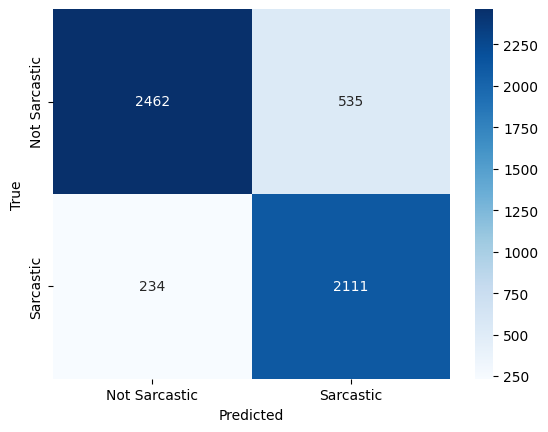

In [ ]:
pred_logits = model.predict({'input_ids': test_encodings['input_ids'], 'attention_mask': test_encodings['attention_mask']})
y_pred = np.argmax(pred_logits.logits, axis=1)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Sarcastic', 'Sarcastic'], yticklabels=['Not Sarcastic', 'Sarcastic'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
model.save_pretrained('./saved_model')
tokenizer.save_pretrained('./saved_model')


('./saved_model/tokenizer_config.json',
 './saved_model/special_tokens_map.json',
 './saved_model/vocab.txt',
 './saved_model/added_tokens.json')